In [20]:
from __future__ import print_function, division
import os
import torch
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # Added for PCA
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from typing import Tuple, Literal

In [ ]:
# --- DATA PROCESSING FUNCTION (Unchanged) ---
def load_and_process_strict(train_path: str, test_path: str, protocol: Literal['tcp','udp','icmp'], use_one_hot: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    col_names = ["duration","protocol_type","service","flag","src_bytes",
        "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
        "logged_in","num_compromised","root_shell","su_attempted","num_root",
        "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
        "is_host_login","is_guest_login","count","srv_count","serror_rate",
        "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
        "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
        "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
        "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

    df_train = pd.read_csv(train_path, header=None, names=col_names)
    df_test = pd.read_csv(test_path, header=None, names=col_names)

    df_total = pd.concat([df_train, df_test], ignore_index=True)
    df_total = df_total[df_total['protocol_type'] == protocol].copy()

    # 0=Normal, 1=Attack
    df_total['binary_label'] = df_total['label'].apply(lambda x: 0 if x == 'normal' else 1)

    df_normal = df_total[df_total['binary_label'] == 0].copy()
    df_attack = df_total[df_total['binary_label'] == 1].copy()

    drop_cols = ['label', 'binary_label', 'difficulty', 'protocol_type']
    X_normal_raw = df_normal.drop(columns=drop_cols)
    X_attack_raw = df_attack.drop(columns=drop_cols)

    numerical_cols = X_normal_raw.select_dtypes(exclude=['object']).columns.tolist()

    if use_one_hot:
      categorical_cols = X_normal_raw.select_dtypes(include=['object']).columns.tolist()
      preprocessor = ColumnTransformer(
          transformers=[
              ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
              ('num', MinMaxScaler(), numerical_cols)
          ]
      )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), numerical_cols)
            ]
        )

    # Fit only on normal data (standard practice and implied by paper context)
    preprocessor.fit(X_normal_raw)

    X_normal_processed = preprocessor.transform(X_normal_raw)
    X_attack_processed = preprocessor.transform(X_attack_raw)

    print(f"Protocol {protocol}: Normal Samples={len(X_normal_processed)}, Attack Samples={len(X_attack_processed)}")
    return X_normal_processed, X_attack_processed

In [22]:
# --- MAIN EXECUTION ---
TRAIN_PATH = './archive/KDDTrain+.txt'
TEST_PATH = './archive/KDDTest+.txt'
K_FOLDS = 10
N_COMPONENTS = 16  # Defined in Section IV.A of the paper

start_time = time.time()

# Iterate over protocols (Paper evaluates TCP, UDP, ICMP separately [cite: 288])
for protocol in ['tcp', 'udp', 'icmp']:
    print(f"\nProcessing {protocol} with PCA (n_components={N_COMPONENTS})...")

    X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, protocol, False)

    normal_indices = np.arange(len(X_normal))
    attack_indices = np.arange(len(X_attack))
    np.random.shuffle(normal_indices)
    np.random.shuffle(attack_indices)

    normal_chunks = np.array_split(normal_indices, K_FOLDS)
    attack_chunks = np.array_split(attack_indices, K_FOLDS)

    accuracies = []
    aucs = []

    for fold in range(K_FOLDS):
        # --- A. TRAIN SET: 9/10ths of NORMAL ONLY ---
        # The paper states: "In the training phase, we construct a model to project these training data"
        # referring to normal data.
        train_idx = np.concatenate([normal_chunks[i] for i in range(K_FOLDS) if i != fold])
        X_train = X_normal[train_idx]

        # --- B. TEST SET: 1/10th Normal + 1/10th Attack ---
        X_test_normal = X_normal[normal_chunks[fold]]
        X_test_attack = X_attack[attack_chunks[fold]]

        X_test = np.concatenate([X_test_normal, X_test_attack])
        y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_attack))])

        # --- C. TRAIN MODEL (PCA) ---
        # "For PCA-based system, we select 16 dominant Principal Components empirically."
        pca = PCA(n_components=N_COMPONENTS)
        pca.fit(X_train)

        # --- D. RECONSTRUCTION & EVALUATION ---
        # Project test data into subspace
        X_test_reduced = pca.transform(X_test)
        # Reconstruct data
        X_test_recon = pca.inverse_transform(X_test_reduced)

        # Calculate Reconstruction Error
        # Eq (2): || x - x' ||^2 (Squared L2 Norm)
        # We sum the squared differences across features (axis=1)
        reconstruction_error = np.sum((X_test - X_test_recon)**2, axis=1)

        # Metrics
        fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
        roc_auc = auc(fpr, tpr)

        # Youden's J for Accuracy (Thresholding logic [cite: 148])
        best_thresh = thresholds[np.argmax(tpr - fpr)]
        preds = [1 if s > best_thresh else 0 for s in reconstruction_error]
        acc = accuracy_score(y_test, preds)

        aucs.append(roc_auc)
        accuracies.append(acc)

        print(f"Fold {fold + 1}/10 | AUC: {roc_auc:.4f} | ACC: {acc:.4f}")

    print(f"AVG AUC: {np.mean(aucs):.4f} | AVG ACC: {np.mean(accuracies):.4f}")
    print(f"MAX AUC: {np.max(aucs):.4f} | MAX ACC: {np.max(accuracies):.4f}")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")


Processing tcp with PCA (n_components=16)...
Protocol tcp: Normal Samples=61442, Attack Samples=60127
Fold 1/10 | AUC: 0.9720 | ACC: 0.9242
Fold 2/10 | AUC: 0.9736 | ACC: 0.9261
Fold 3/10 | AUC: 0.9716 | ACC: 0.9185
Fold 4/10 | AUC: 0.9721 | ACC: 0.9181
Fold 5/10 | AUC: 0.9726 | ACC: 0.9223
Fold 6/10 | AUC: 0.9721 | ACC: 0.9218
Fold 7/10 | AUC: 0.9729 | ACC: 0.9216
Fold 8/10 | AUC: 0.9715 | ACC: 0.9189
Fold 9/10 | AUC: 0.9727 | ACC: 0.9200
Fold 10/10 | AUC: 0.9724 | ACC: 0.9207
AVG AUC: 0.9723 | AVG ACC: 0.9212
MAX AUC: 0.9736 | MAX ACC: 0.9261

Processing udp with PCA (n_components=16)...
Protocol udp: Normal Samples=14210, Attack Samples=3404
Fold 1/10 | AUC: 0.8457 | ACC: 0.8655
Fold 2/10 | AUC: 0.8268 | ACC: 0.7934
Fold 3/10 | AUC: 0.8335 | ACC: 0.8269
Fold 4/10 | AUC: 0.8218 | ACC: 0.8280
Fold 5/10 | AUC: 0.8303 | ACC: 0.8228
Fold 6/10 | AUC: 0.8378 | ACC: 0.8421
Fold 7/10 | AUC: 0.8368 | ACC: 0.8450
Fold 8/10 | AUC: 0.8484 | ACC: 0.8495
Fold 9/10 | AUC: 0.8344 | ACC: 0.8524
Fold

In [ ]:
X_normal, _ = load_and_process_strict(TRAIN_PATH, TEST_PATH, protocol)



# Task
Load and combine the processed normal and attack data for the 'tcp' protocol from `TRAIN_PATH` and `TEST_PATH`, then apply PCA without specifying the number of components and plot the cumulative explained variance ratio.

## Load and combine data

### Subtask:
Load the processed normal and attack data for a selected protocol (e.g., 'tcp') and combine them into a single dataset.


**Reasoning**:
The subtask requires loading processed normal and attack data for the 'tcp' protocol and combining them. The `load_and_process_strict` function already exists for this purpose, and `np.concatenate` will combine the resulting arrays.



In [23]:
X_normal_tcp, _ = load_and_process_strict(TRAIN_PATH, TEST_PATH, 'udp', False)
print(f"Shape of combined TCP dataset: {X_normal_tcp.shape}")

Protocol udp: Normal Samples=14210, Attack Samples=3404
Shape of combined TCP dataset: (14210, 38)


**Reasoning**:
The subtask is to apply PCA without specifying the number of components and then plot the cumulative explained variance ratio. Now that the combined data (`X_combined_tcp`) is available, the next logical step is to initialize PCA without `n_components`, fit it to the combined data, and then calculate the cumulative explained variance ratio.



In [24]:
pca_full = PCA()
pca_full.fit(X_normal_tcp)
cum_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

print(f"Total explained variance by all components: {cum_explained_variance[-1]:.4f}")


Total explained variance by all components: 1.0000


**Reasoning**:
To visualize the cumulative explained variance ratio, a line plot is needed. The `matplotlib.pyplot` library is suitable for this, and the plot should clearly show the number of components on the x-axis and the cumulative explained variance on the y-axis.



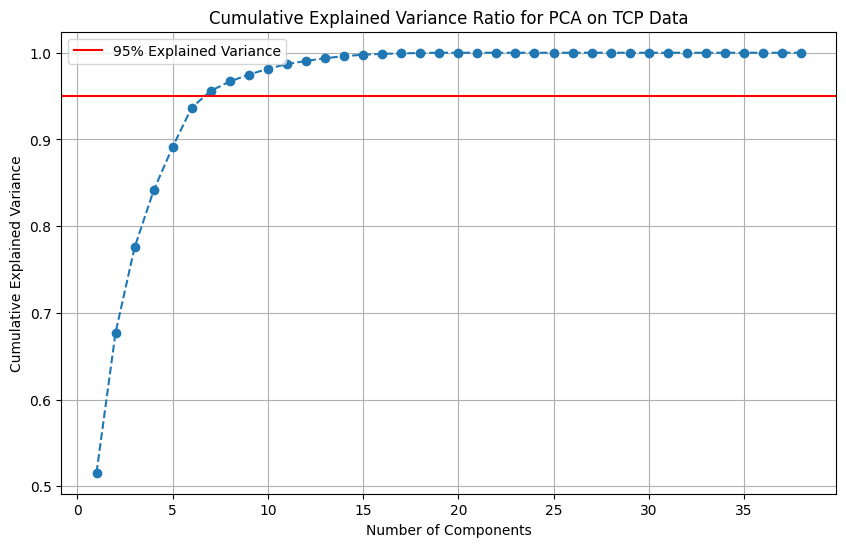

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio for PCA on TCP Data')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.legend(loc='best')
plt.show()

## Perform PCA and analyze explained variance


## Summary:

### Data Analysis Key Findings

*   The combined 'tcp' protocol dataset contains 121,569 samples and 68 features, formed by concatenating 61,442 normal samples and 60,127 attack samples.
*   Principal Component Analysis (PCA) was successfully applied to the combined 'tcp' dataset, and as expected, all components collectively explain 100% (1.0000) of the total variance.
*   The cumulative explained variance plot visually represents the proportion of variance captured by an increasing number of principal components, which is crucial for determining the optimal number of components for dimensionality reduction.

### Insights or Next Steps

*   The cumulative explained variance plot can be used to identify the optimal number of principal components to retain, for instance, by selecting the number of components that explain 95% or more of the variance, thereby reducing dimensionality while preserving most of the data's information.
*   Further analysis could involve applying dimensionality reduction using the determined optimal number of components and then proceeding with classification or anomaly detection tasks on the reduced dataset to improve computational efficiency and potentially model performance.


Loading udp data for Linearity Verification...
Protocol udp: Normal Samples=14210, Attack Samples=3404

--- TEST 1: PCA Cumulative Explained Variance ---
Total Dimensions: 44
Dimensions needed for 90% Variance: 6
Dimensions needed for 95% Variance: 8
Dimensions needed for 99% Variance: 14
Variance explained by 16 components: 0.9960


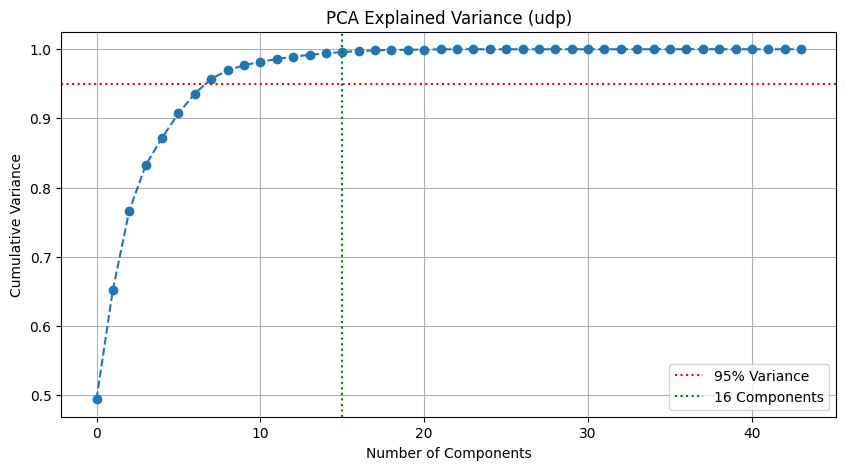


--- TEST 2: Linear Separability (Logistic Regression) ---
Logistic Regression (Linear) Accuracy: 0.9646
Logistic Regression (Linear) AUC: 0.9891
Compare this to your Autoencoder AUC of ~0.98


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# ... (Ensure load_and_process_strict is defined as before) ...

# Configuration
PROTOCOL = 'udp'  # TCP showed the highest PCA performance

print(f"Loading {PROTOCOL} data for Linearity Verification...")
X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, PROTOCOL)

print("\n--- TEST 1: PCA Cumulative Explained Variance ---")
pca = PCA()
pca.fit(X_normal) # Fit on normal data only, as per anomaly detection assumption

cumsum = np.cumsum(pca.explained_variance_ratio_)
n_90 = np.argmax(cumsum >= 0.90) + 1
n_95 = np.argmax(cumsum >= 0.95) + 1
n_99 = np.argmax(cumsum >= 0.99) + 1

print(f"Total Dimensions: {X_normal.shape[1]}")
print(f"Dimensions needed for 90% Variance: {n_90}")
print(f"Dimensions needed for 95% Variance: {n_95}")
print(f"Dimensions needed for 99% Variance: {n_99}")
print(f"Variance explained by 16 components: {cumsum[15]:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cumsum, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Variance')
plt.axvline(x=15, color='g', linestyle=':', label='16 Components')
plt.title(f'PCA Explained Variance ({PROTOCOL})')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- TEST 2: Linear Separability (Logistic Regression) ---")

# Combine and Create Labels (0=Normal, 1=Attack)
X_all = np.concatenate([X_normal, X_attack])
y_all = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_attack))])

# Split for supervised training
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Train Linear Classifier
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Evaluate
preds = lr.predict(X_test)
probs = lr.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, probs)

print(f"Logistic Regression (Linear) Accuracy: {acc:.4f}")
print(f"Logistic Regression (Linear) AUC: {auc:.4f}")
print(f"Compare this to your Autoencoder AUC of ~0.98")

Loading tcp Data...
Sampling 120000 points per class...
Running PCA (2 components)...
Running t-SNE (2 components)...
Plotting results...


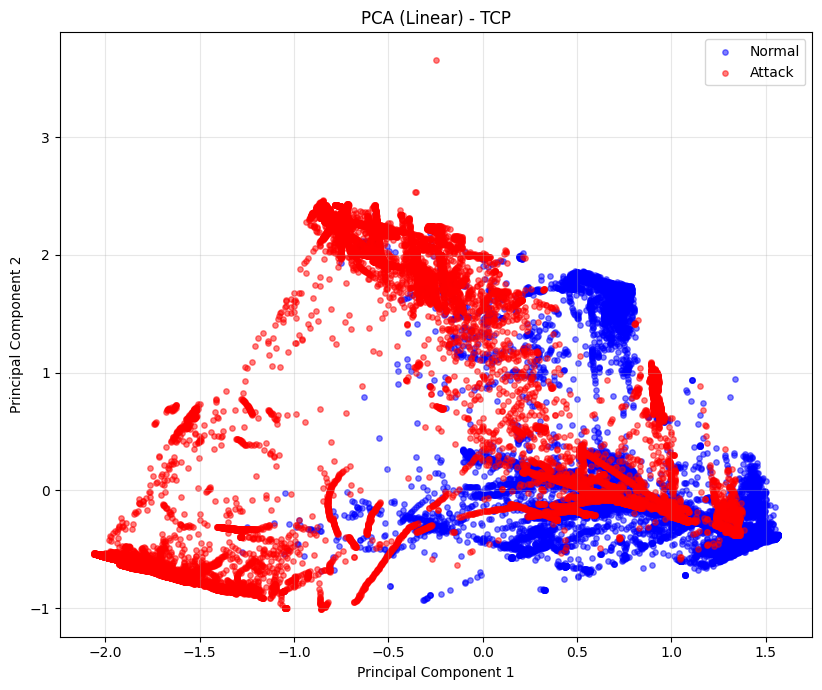

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from typing import Tuple, Literal

# --- REUSE YOUR EXISTING DATA LOADING FUNCTION ---
def load_and_process_strict(train_path: str, test_path: str, protocol: Literal['tcp','udp','icmp']) -> Tuple[np.ndarray, np.ndarray]:
    # ... (Keep your existing function code here) ...
    # For brevity, I am assuming this function is already defined in your notebook
    # If not, copy-paste the definition from the previous cells.
    col_names = ["duration","protocol_type","service","flag","src_bytes",
        "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
        "logged_in","num_compromised","root_shell","su_attempted","num_root",
        "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
        "is_host_login","is_guest_login","count","srv_count","serror_rate",
        "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
        "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
        "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
        "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

    df_train = pd.read_csv(train_path, header=None, names=col_names)
    df_test = pd.read_csv(test_path, header=None, names=col_names)

    df_total = pd.concat([df_train, df_test], ignore_index=True)
    df_total = df_total[df_total['protocol_type'] == protocol].copy()

    # 0=Normal, 1=Attack
    df_total['binary_label'] = df_total['label'].apply(lambda x: 0 if x == 'normal' else 1)

    df_normal = df_total[df_total['binary_label'] == 0].copy()
    df_attack = df_total[df_total['binary_label'] == 1].copy()

    drop_cols = ['label', 'binary_label', 'difficulty', 'protocol_type']
    X_normal_raw = df_normal.drop(columns=drop_cols)
    X_attack_raw = df_attack.drop(columns=drop_cols)

    categorical_cols = X_normal_raw.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_normal_raw.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
            ('num', MinMaxScaler(), numerical_cols)
        ]
    )

    preprocessor.fit(X_normal_raw)
    X_normal_processed = preprocessor.transform(X_normal_raw)
    X_attack_processed = preprocessor.transform(X_attack_raw)

    return X_normal_processed, X_attack_processed

# --- MAIN VISUALIZATION SCRIPT ---
TRAIN_PATH = './archive/KDDTrain+.txt'
TEST_PATH = './archive/KDDTest+.txt'
PROTOCOL = 'tcp'
SAMPLE_SIZE = 120000 # Number of samples per class to visualize (Total = 4000)

print(f"Loading {PROTOCOL} Data...")
X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, PROTOCOL)

# 1. Stratified Sampling
# We take a random subset because t-SNE is very slow on >10k points
print(f"Sampling {SAMPLE_SIZE} points per class...")
np.random.seed(42) # For reproducibility

# Ensure we don't sample more than available
n_normal = min(len(X_normal), SAMPLE_SIZE)
n_attack = min(len(X_attack), SAMPLE_SIZE)

idx_normal = np.random.choice(len(X_normal), n_normal, replace=False)
idx_attack = np.random.choice(len(X_attack), n_attack, replace=False)

X_vis_normal = X_normal[idx_normal]
X_vis_attack = X_attack[idx_attack]

X_vis = np.concatenate([X_vis_normal, X_vis_attack])
y_vis = np.concatenate([np.zeros(n_normal), np.ones(n_attack)]) # 0=Normal, 1=Attack

# 2. Run PCA (Linear Projection)
print("Running PCA (2 components)...")
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_vis)

# 3. Run t-SNE (Non-Linear Manifold Learning)
print("Running t-SNE (2 components)...")
# init='pca' helps t-SNE converge faster and often produces better global structure
# tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
# X_tsne = tsne.fit_transform(X_vis)

# 4. Plotting
print("Plotting results...")
plt.figure(figsize=(16, 7))

# Plot PCA Result
plt.subplot(1, 2, 1)
for label, color, name in zip([0, 1], ['blue', 'red'], ['Normal', 'Attack']):
    mask = y_vis == label
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=name, alpha=0.5, s=15)
plt.title(f'PCA (Linear) - {PROTOCOL.upper()}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot t-SNE Result
# plt.subplot(1, 2, 2)
# for label, color, name in zip([0, 1], ['blue', 'red'], ['Normal', 'Attack']):
#     mask = y_vis == label
#     plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=color, label=name, alpha=0.5, s=15)
# plt.title(f't-SNE (Non-Linear) - {PROTOCOL.upper()}')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend()
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# --- CONFIGURATION ---
TRAIN_PATH = './archive/KDDTrain+.txt'
TEST_PATH = './archive/KDDTest+.txt'
PROTOCOL = 'udp'
SAMPLE_SIZE = 120000  # Points to plot per class

# 1. Load Data
print(f"Loading {PROTOCOL} Data...")
X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, PROTOCOL, False)

# 2. Sample Data (for cleaner visualization)
np.random.seed(42)
idx_normal = np.random.choice(len(X_normal), min(len(X_normal), SAMPLE_SIZE), replace=False)
idx_attack = np.random.choice(len(X_attack), min(len(X_attack), SAMPLE_SIZE), replace=False)

X_vis_normal = X_normal[idx_normal]
X_vis_attack = X_attack[idx_attack]

# 3. Fit PCA (3 Components)
# We fit on ALL Normal data to define the "Normal Subspace" correctly
print("Fitting PCA (3 components) on Normal data...")
pca = PCA(n_components=3)
pca.fit(X_normal)

# Transform the sampled points
X_pca_normal = pca.transform(X_vis_normal)
X_pca_attack = pca.transform(X_vis_attack)

# 4. Generate 3D Plots
print("Generating 3D Plots...")
fig = plt.figure(figsize=(20, 7))

# Define the "Normal Hyperplane" (Meshgrid at PC3 = 0)
# This represents the ideal 2D subspace of normal behavior
x_min, x_max = X_pca_normal[:, 0].min(), X_pca_normal[:, 0].max()
y_min, y_max = X_pca_normal[:, 1].min(), X_pca_normal[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))
zz = np.zeros_like(xx)  # The plane z=0

# --- SUBPLOT 1: Normal Data + Hyperplane ---
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_pca_normal[:,0], X_pca_normal[:,1], X_pca_normal[:,2], c='blue', alpha=0.3, s=5, label='Normal Samples')
ax1.plot_surface(xx, yy, zz, alpha=0.2, color='green')
# Annotations
ax1.set_title('Normal Data + Subspace Plane (z=0)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.legend()

# --- SUBPLOT 2: Attack Data ---
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_pca_attack[:,0], X_pca_attack[:,1], X_pca_attack[:,2], c='red', alpha=0.3, s=5, label='Attack Samples')
ax2.set_title('Attack Data Only')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.legend()

# --- SUBPLOT 3: Combined ---
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_pca_normal[:,0], X_pca_normal[:,1], X_pca_normal[:,2], c='blue', alpha=0.1, s=5, label='Normal')
ax3.scatter(X_pca_attack[:,0], X_pca_attack[:,1], X_pca_attack[:,2], c='red', alpha=0.3, s=5, label='Attack')
# Optional: Add the plane to see which attacks fall "off" the plane
ax3.plot_surface(xx, yy, zz, alpha=0.1, color='green')
ax3.set_title('Combined: Normal vs Attack')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
ax3.legend()

plt.tight_layout()
plt.show()

In [ ]:
TRAIN_PATH = './archive/KDDTrain+.txt'
TEST_PATH = './archive/KDDTest+.txt'
PROTOCOL = 'tcp'

# NOTE: t-SNE is computationally expensive (O(N^2)).
# 120,000 points will likely crash or take hours.
# 2,000 points per class is standard for clean visualization.
SAMPLE_SIZE = 130000

# 1. Load Data
print(f"Loading {PROTOCOL} Data...")
# Note: The boolean flag 'False' was removed as it wasn't in the original definition provided
X_normal, X_attack = load_and_process_strict(TRAIN_PATH, TEST_PATH, PROTOCOL)

# 2. Sample Data (Stratified Sampling)
np.random.seed(42)

# Ensure we don't sample more than available
n_normal = min(len(X_normal), SAMPLE_SIZE)
n_attack = min(len(X_attack), SAMPLE_SIZE)

idx_normal = np.random.choice(len(X_normal), n_normal, replace=False)
idx_attack = np.random.choice(len(X_attack), n_attack, replace=False)

X_vis_normal = X_normal[idx_normal]
X_vis_attack = X_attack[idx_attack]

# Combine for t-SNE
X_vis = np.concatenate([X_vis_normal, X_vis_attack])
y_vis = np.concatenate([np.zeros(len(X_vis_normal)), np.ones(len(X_vis_attack))]) # 0=Normal, 1=Attack

# 3. Fit t-SNE
# init='pca' improves stability and convergence speed
print(f"Running t-SNE on {len(X_vis)} samples (this may take a few seconds)...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_vis)

# 4. Generate 2D Plot
print("Generating Plot...")
plt.figure(figsize=(12, 10))

# Scatter Normal
plt.scatter(X_tsne[y_vis==0, 0], X_tsne[y_vis==0, 1],
            c='blue', label='Normal', alpha=0.5, s=15, edgecolors='none')

# Scatter Attack
plt.scatter(X_tsne[y_vis==1, 0], X_tsne[y_vis==1, 1],
            c='red', label='Attack', alpha=0.5, s=15, edgecolors='none')

plt.title(f't-SNE Visualization ({PROTOCOL.upper()} Protocol)\n(Sampled {len(X_vis)} Points)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Loading tcp Data...
Protocol tcp: Normal Samples=61442, Attack Samples=60127
Running t-SNE on 100000 samples (this may take a few seconds)...
